In [1]:
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2
import sys
sys.path.insert(1, '../../SyMBac/')
from matplotlib.ticker import MaxNLocator

from matplotlib import rc
rc('text', usetex=True)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
import matplotlib
from matplotlib_scalebar.scalebar import ScaleBar
import tifffile
from microfilm.colorify import cmaps_def
import scipy
import scienceplots
from seaborn import move_legend
from copy import deepcopy
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True

from skimage.util import img_as_uint
from skimage.draw import disk
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation
import seaborn as sns
import pandas as pd
import sys
sys.path.insert(0, "../")
from SyMBac.drawing import raster_cell, OPL_to_FL, convert_to_3D
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale


def bin_data(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])

def bin_data_mid(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in sorted([x.mid  for x in pd.cut(df[column], bins=bins).unique()]) ])


def bin_data_range(bins, column, df, new_column_name):
    return pd.cut(df[column], bins=bins, labels=[i for i in ([f"[{int(x.left+1)}, {int(x.right+1)})"  for x in pd.cut(df[column], bins=bins).unique()]) ])


all_results = pd.read_pickle("../../single_molecule_analysis/sources_of_error.pickle")
hist_data = all_results.groupby(["True N molecules", "Cell type"], as_index=False).mean().melt(["Cell type", "True N molecules"])
hist_data['variable'] = pd.Categorical(hist_data['variable'], reversed(["Observed N molecules", "N molecules lost to DoF", "N molecules lost to diffraction"]))
#ist_data = hist_data.reindex(index=hist_data.index[::-1])


(18, 120, 40)


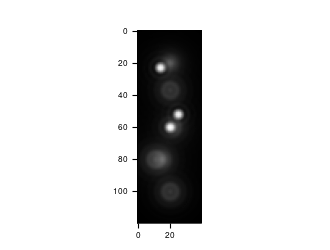

In [2]:
pixel_size = 0.05
scale = 1
pixel_size = pixel_size/scale
def simulate_molecule_counting(N_molecules, length, width):
    OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)
    volume = np.sum(OPL_cell)
    density = N_molecules/volume
    FL_cell = OPL_to_FL(OPL_cell, density = density)
    true_N_molecules = np.sum(FL_cell)
    return FL_cell, true_N_molecules

length = 5
width = 1
OPL_cell = raster_cell(length/pixel_size,width/pixel_size,separation=False)

OPL_cell_3D = convert_to_3D(OPL_cell)
OPL_cell_3D = np.pad(OPL_cell_3D, ((0,0),(10,10),(10,10)))

my_kernel = PSF_generator(
    radius = 30, 
    wavelength = 0.55, 
    NA=1.49, 
    n = 1.518, 
    resize_amount=1, 
    pix_mic_conv=pixel_size, 
    apo_sigma = 10, 
    mode="3d fluo", 
    condenser="Ph3", 
    z_height = OPL_cell_3D.shape[0],
    pz = 0.5,
    working_distance = 170
)
my_kernel.calculate_PSF()
my_kernel.kernel /= np.sum(my_kernel.kernel)

FL_cell_3D = np.zeros_like(OPL_cell_3D).astype(np.float32)
print(FL_cell_3D.shape)

FL_cell_3D[9,60,20] = 1
FL_cell_3D[9,23,14] = 1
FL_cell_3D[9,52,25] = 1



FL_cell_3D[2,20,20] = 1
FL_cell_3D[2,80,15] = 1
FL_cell_3D[2,60,22] = 1

FL_cell_3D[17,100,20] = 1
FL_cell_3D[17,80,11] = 1
FL_cell_3D[17,37,20] = 1


localisation_data = pd.DataFrame(np.argwhere(FL_cell_3D)[:,1:] * (pixel_size * 1000))
localisation_data.columns = ["y [nm]", "x [nm]"]
localisation_data["Photon #"] = 2250

conv_FL_cell_3D = np.array([convolve_rescale(cell_layer, PSF_layer, 1, False) for cell_layer, PSF_layer in zip(FL_cell_3D, my_kernel.kernel)])


conv_FL_cell = conv_FL_cell_3D.sum(axis=0)

conv_FL_cell = conv_FL_cell/(conv_FL_cell.max())
conv_FL_cell = img_as_uint(conv_FL_cell)
plt.imshow(conv_FL_cell**0.7, cmap="Greys_r")



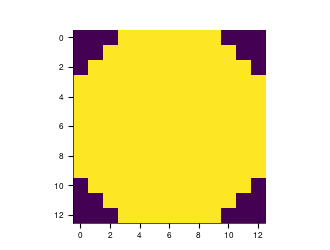

In [3]:
circle = np.zeros((13,13))
rr, cc = disk((6, 6), 7, shape=(13,13))
circle[rr,cc] = 1
plt.imshow(circle)

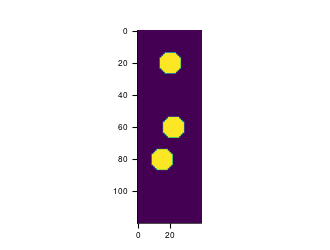

In [4]:
top_layer = dilation(FL_cell_3D[2,:,:], circle)
plt.imshow(top_layer)

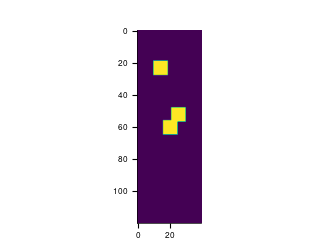

In [5]:
middle_layer = dilation(FL_cell_3D[9,:,:], np.ones((9,9)))
plt.imshow(middle_layer)

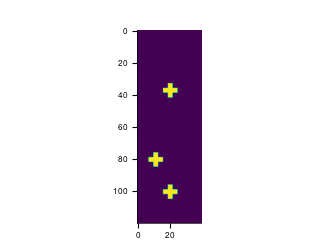

In [6]:
cross = np.zeros((9,9))
cross[:,3:6] = 1
cross[3:6,:] = 1

bottom_layer = dilation(FL_cell_3D[17,:,:], cross)
plt.imshow(bottom_layer)

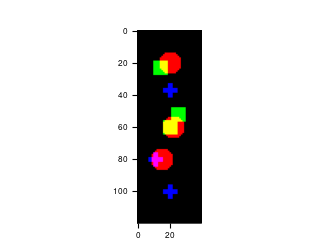

In [7]:
layers_RGB = np.zeros(top_layer.shape + (3,))
layers_RGB[:,:,0] = top_layer
layers_RGB[:,:,1] = middle_layer
layers_RGB[:,:,2] = bottom_layer
plt.imshow(layers_RGB)

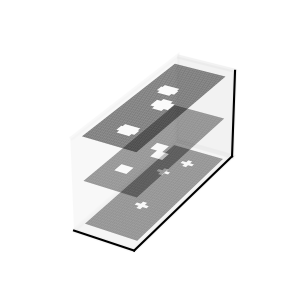

In [8]:
xx, yy = np.meshgrid(np.linspace(0,conv_FL_cell.shape[1],conv_FL_cell.shape[1]), np.linspace(0,conv_FL_cell.shape[0],conv_FL_cell.shape[0]))

fig = plt.figure(figsize = (1,1), dpi = 300)
points_3D = fig.add_subplot(1, 1, 1, projection='3d')
points_3D.grid(False)
Z =  1*np.ones(xx.shape)
points_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(top_layer), shade=False, alpha=0.5, linewidth=0)
Z =  0*np.ones(xx.shape)
points_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(middle_layer), shade=False, alpha=0.4, linewidth=0)
Z =  -1*np.ones(xx.shape)
points_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(bottom_layer), shade=False, alpha=0.4, linewidth=0)

points_3D.set_box_aspect((np.ptp(xx), np.ptp(yy), np.ptp(yy)*0.5)) 
points_3D.set_xticks([])
points_3D.set_yticks([])
points_3D.set_zticks([])

plt.savefig("a.svg")

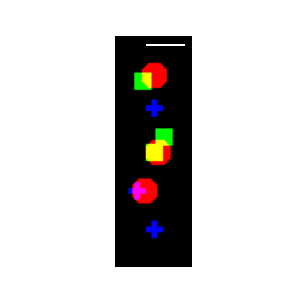

In [9]:
fig, GT = plt.subplots(1,1, figsize=(1,1),  dpi = 300)
plt.imshow(layers_RGB)
scalebar = ScaleBar(0.05, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) # 1 micron
GT.add_artist(scalebar)
plt.xticks([0])
plt.yticks([0])
plt.axis("off")
plt.savefig("b.svg")

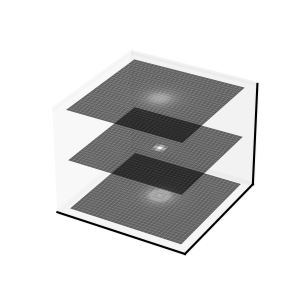

In [10]:
fig = plt.figure(figsize=(1,1),  dpi = 300)
PSF_3D = fig.add_subplot(1, 1, 1, projection='3d')

xx, yy = np.meshgrid(np.linspace(0,my_kernel.kernel.shape[1],my_kernel.kernel.shape[1]), np.linspace(0,my_kernel.kernel.shape[1],my_kernel.kernel.shape[1]))
#xx, yy = xx*conv_FL_cell, yy*conv_FL_cell
Z =  10*np.ones(xx.shape)
PSF_3D.grid(False)
Z =  1*np.ones(xx.shape)
PSF_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(my_kernel.kernel[0]/my_kernel.kernel[2].max()), shade=False, alpha=0.6, linewidth=0)
Z =  0*np.ones(xx.shape)
PSF_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(my_kernel.kernel[9]/my_kernel.kernel[9].max()), shade=False, alpha=0.6, linewidth=0)
Z =  -1*np.ones(xx.shape)
PSF_3D.plot_surface(xx, yy, Z, facecolors=plt.cm.gray(my_kernel.kernel[-1]/my_kernel.kernel[-2].max()), shade=False, alpha=0.6, linewidth=0)
PSF_3D.set_box_aspect((np.ptp(xx), np.ptp(yy), np.ptp(yy)*0.8)) 
PSF_3D.set_xticks([])
PSF_3D.set_yticks([])
PSF_3D.set_zticks([])
plt.savefig("c.svg")

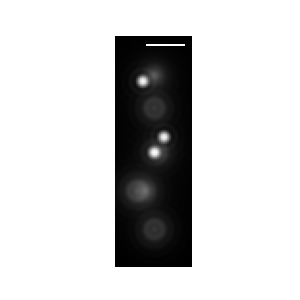

In [11]:
fig, CONV = plt.subplots(1,1, figsize=(1,1),  dpi = 300)

plt.imshow(conv_FL_cell**0.7, cmap="Greys_r")
scalebar = ScaleBar(0.05, "um", label_loc=None,  box_alpha=0, scale_loc="none", color="white", length_fraction=0.5) # 1 micron
CONV.add_artist(scalebar)
plt.xticks([0])
plt.yticks([0])
plt.axis("off")
plt.savefig("d.svg")

In [12]:
hist_data['variable'] = hist_data['variable'].replace({
    'Observed N molecules': 'Observed molecules',
    'N molecules lost to DoF': 'Molecules lost to focus',
    'N molecules lost to diffraction': 'Molecules lost to diffraction'
})


/tmp/ipykernel_1599520/3277952150.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])
/tmp/ipykernel_1599520/3277952150.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])
/tmp/ipykernel_1599520/3277952150.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])


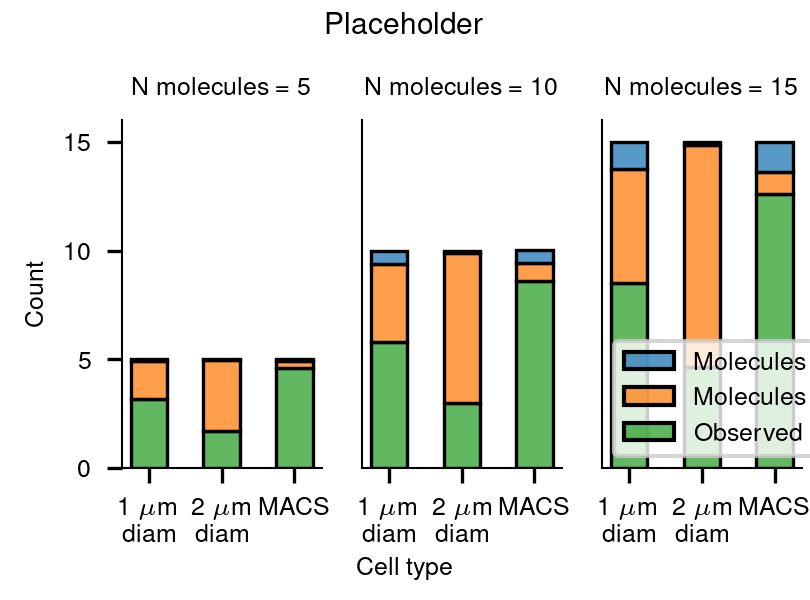

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(2.7, 2), dpi=300)

# First plot
g = sns.histplot(
    data = hist_data.query("`True N molecules` ==5"),
    x = "Cell type", 
    hue = "variable", weights = "value", multiple = "stack", shrink = 0.5, legend=False,
    ax=axs[0]
)
g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])
axs[0].set_ylim(0,16)
axs[0].set_xlabel("")
axs[0].set_title("N molecules = 5")

# Second plot
g = sns.histplot(
    data = hist_data.query("`True N molecules` == 10"),
    x = "Cell type", 
    hue = "variable", weights = "value", multiple = "stack", shrink = 0.5, legend=False,
    ax=axs[1]
)
axs[1].set_yticks([])
axs[1].set_ylabel("")
axs[1].set_ylim(0,16)
g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])
axs[1].set_title("N molecules = 10")
axs[1].set_xlabel("")

# Third plot
g = sns.histplot(
    data = hist_data.query("`True N molecules` == 15"),
    x = "Cell type", 
    hue = "variable", weights = "value", multiple = "stack", shrink = 0.5,
    ax=axs[2]
)
axs[2].set_yticks([])
axs[2].set_ylabel("")
axs[2].set_ylim(0,16)
axs[2].set_xlabel("")
g.set_xticklabels(["1 $\mu$m\ndiam","2 $\mu$m\ndiam","MACS"])
axs[2].set_title("N molecules = 15")
g.legend_.set_title(None)
#move_legend(axs[2], (-2.2,-0.27), ncol=3)
plt.suptitle("Placeholder")
fig.subplots_adjust(left=0.15, bottom=0.22, right=0.99, top=0.8)
fig.text(0.5, 0.04, 'Cell type', ha='center')
plt.savefig("e.svg")

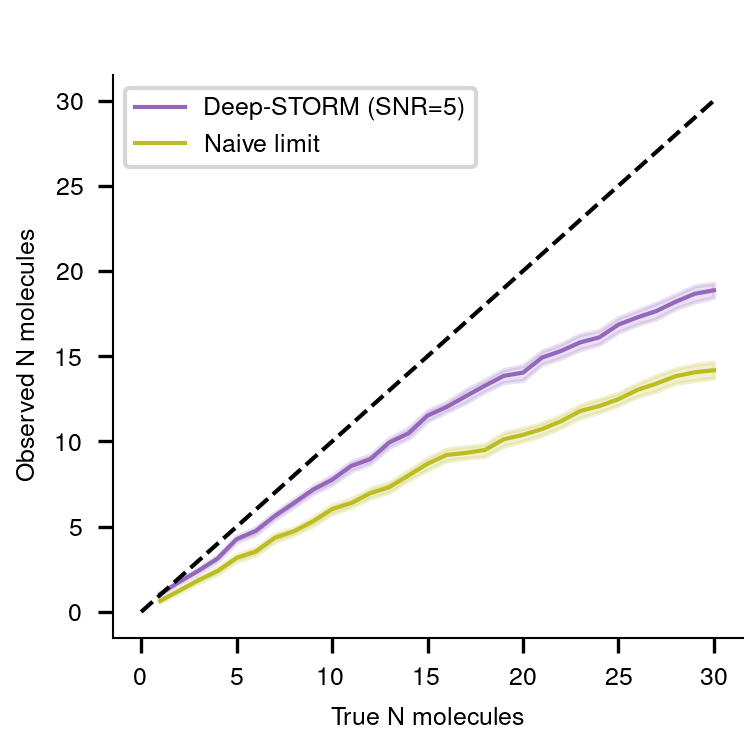

In [14]:
fig, DEEPSTORM_1 = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=300)

combined_data_normal = pd.read_pickle("../../single_molecule_analysis/combined_data_normal.pickle")
sns.lineplot(x = combined_data_normal["True"], y = combined_data_normal["Observed"], c = "C4", label = "Deep-STORM (SNR=5)")

#combined_data_infinite_SNR = pd.read_pickle("../../single_molecule_analysis/combined_data_infinite_SNR.picke")
#sns.lineplot(x = combined_data_infinite_SNR["True"], y = combined_data_infinite_SNR["Observed"], c = "C3" , label = "Deep-STORM (SNR=$\infty$)")

plt.plot([0,30],[0,30], linestyle="--", c = "k")
plt.xlabel("True N molecules")
plt.ylabel("Observed N molecules")

naive_comparison_results = pd.read_pickle("../../single_molecule_analysis/naive_comparison_results.pickle")
sns.lineplot(data = naive_comparison_results, x = "True N molecules", y = "Observed N molecules", c = "C8", label = "Naive limit")
fig.subplots_adjust(left=0.15, bottom=0.15, right=0.99, top=0.9)
plt.savefig("g.svg")

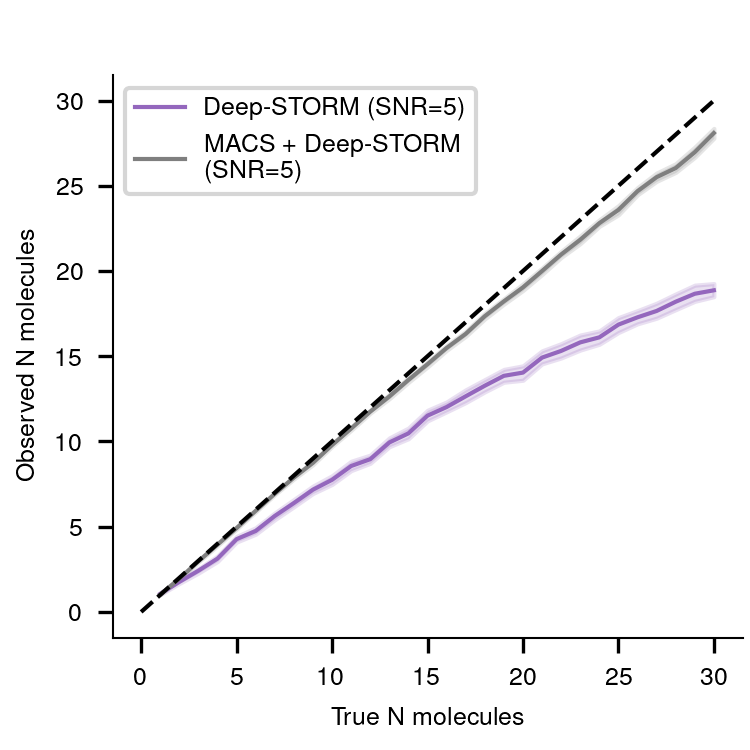

In [15]:

fig, DEEPSTORM_2 = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=300)

sns.lineplot(x = combined_data_normal["True"], y = combined_data_normal["Observed"], c = "C4", label = "Deep-STORM (SNR=5)")

#combined_data_no_DoF = pd.read_pickle("../../single_molecule_analysis/combined_data_no_DoF.pickle")
#sns.lineplot(x = combined_data_no_DoF["True"], y = combined_data_no_DoF["Observed"], c = "C6", label = "Deep-STORM (SNR=5,\nperfect focus)")

combined_data_MACS = pd.read_pickle("../../single_molecule_analysis/combined_data_MACS.pickle")
sns.lineplot(x = combined_data_MACS["True"], y = combined_data_MACS["Observed"], c = "C7", label = "MACS + Deep-STORM \n(SNR=5)")


plt.plot([0,30],[0,30], linestyle="--", c = "k")
plt.xlabel("True N molecules")
plt.ylabel("Observed N molecules")
fig.subplots_adjust(left=0.15, bottom=0.15, right=0.99, top=0.9)
plt.savefig("i.svg")

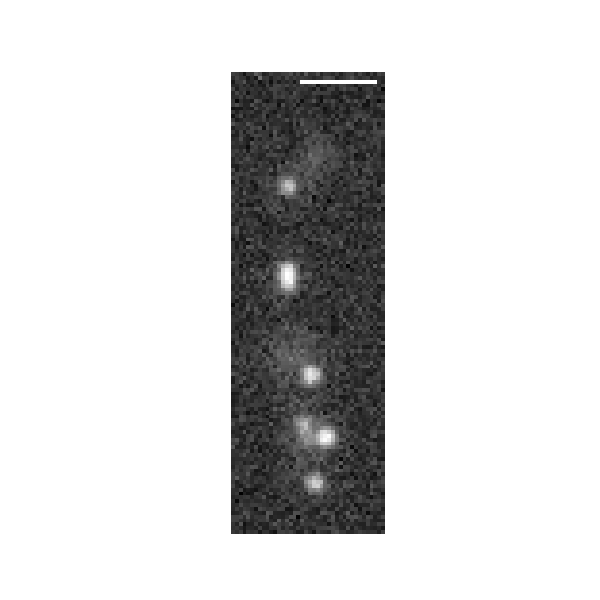

In [205]:
DS_data = tifffile.imread("../../single_molecule_analysis/DEEPSTORM_training_data/SimulatedDataset.tif")

DS_locs = pd.read_csv("../../single_molecule_analysis/DEEPSTORM_training_data/SimulatedDataset.csv")
frame = 2004
y_data, x_data = DS_locs.query("frame == @frame")["y [nm]"]/(pixel_size*1000), DS_locs.query("frame == @frame")["x [nm]"]/(pixel_size*1000)

fix, ax = plt.subplots(1, 1, figsize = (2,2), dpi = 300)
plt.imshow(DS_data[frame-1], cmap = "Greys_r")
#plt.scatter(x_data,y_data, c = "r")
scalebar = ScaleBar(pixel_size, "um", length_fraction=1, scale_loc="none",box_alpha=0, color="white", box_color="k") # 1 micon
ax.add_artist(scalebar)
plt.axis(False)
plt.savefig("normal_cell.svg")
plt.show()

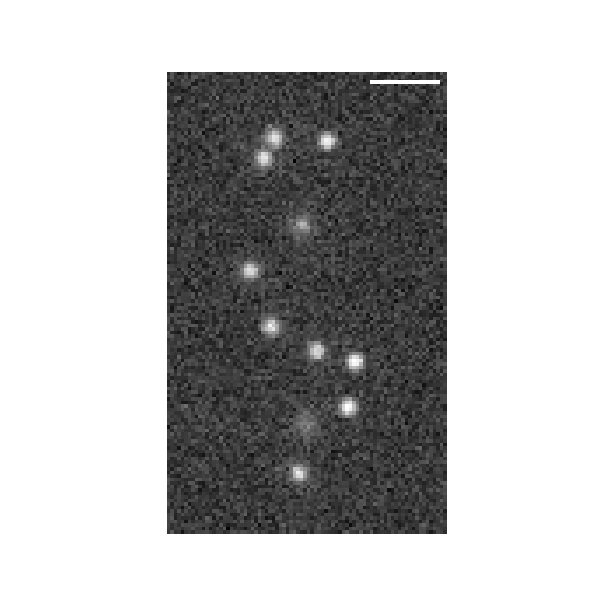

In [203]:
DS_data = tifffile.imread("../../single_molecule_analysis/DEEPSTORM_MACS_training_data//SimulatedDataset.tif")

DS_locs = pd.read_csv("../../single_molecule_analysis/DEEPSTORM_MACS_training_data/SimulatedDataset.csv")

y_data, x_data = DS_locs.query("frame == @frame")["y [nm]"]/(pixel_size*1025), DS_locs.query("frame == @frame")["x [nm]"]/(pixel_size*1025)

fix, ax = plt.subplots(1, 1, figsize = (2,2), dpi = 300)
plt.imshow(DS_data[frame-1], cmap = "Greys_r")
plt.axis(False)
scalebar = ScaleBar(pixel_size, "um", length_fraction=0.5, scale_loc="none",box_alpha=0, color="white", box_color="k") # 1 micon
ax.add_artist(scalebar)
plt.savefig("MACS.svg")
plt.show()

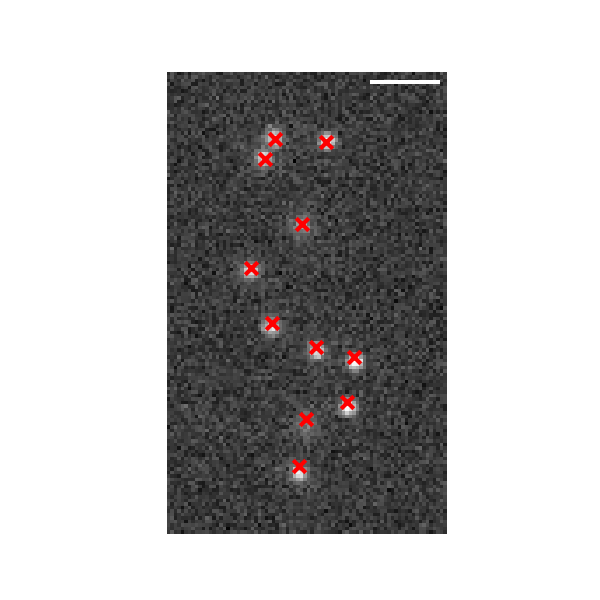

In [204]:
fix, ax = plt.subplots(1, 1, figsize = (2,2), dpi = 300)
plt.imshow(DS_data[frame-1], cmap = "Greys_r")
plt.scatter(x_data,y_data, c = "r", marker="x")
plt.axis(False)
scalebar = ScaleBar(pixel_size, "um", length_fraction=0.5, scale_loc="none",box_alpha=0, color="white", box_color="k") # 1 micon
ax.add_artist(scalebar)
plt.savefig("MACS_localised.svg")
plt.show()